<a href="https://colab.research.google.com/github/saini-himanshu/emotion-ai/blob/main/FacialKeyPointsPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH =  "drive/MyDrive/Colab Notebooks/EmotionAI/"
# PATH = ''

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv(PATH+'Dataset/facial_keypoints_data.csv')

In [5]:
data.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [7]:
o_ix = {
    "left_eye":[0,1,4,5,6,7],
    "right_eye":[2,3,8,9,10,11],
    "left_eyebrow":[12,13,14,15],
    "right_eyebrow":[16,17,18,19],
    "nose":[20,21],
    "mouth":[22,23,24,25,26,27,28,29]
}

In [8]:
keypoints = data.iloc[:,:-1]
images = data.iloc[:,-1]

In [9]:
keypoints.shape

(2140, 30)

In [10]:
images.shape

(2140,)

In [11]:
images = images.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(96, 96))

In [12]:
images[0].shape

(96, 96)

Some random Image visualizations

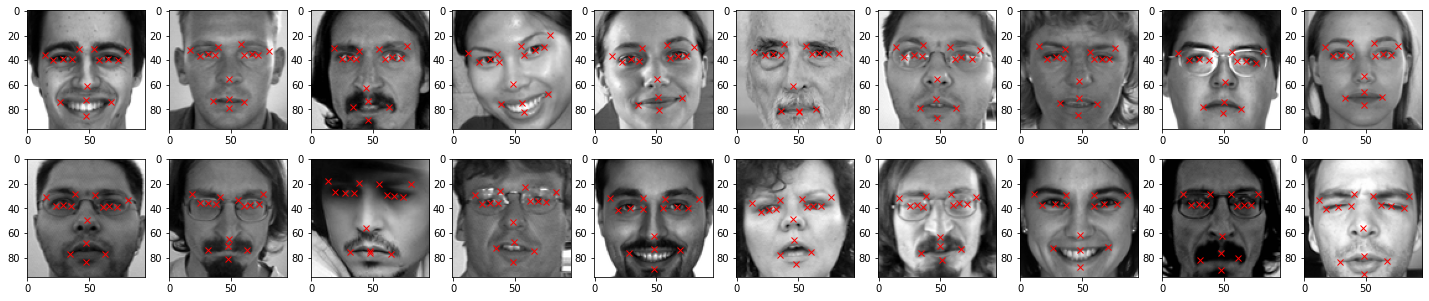

In [13]:
fig = plt.figure(figsize=(25, 5))

for i in range(20):
    k = random.randint(1, len(images))
    ax = fig.add_subplot(2, 10, i + 1)    
    plt.imshow(images[k], cmap='gray')
    for j in range(1,31,2):
        plt.plot(keypoints.loc[k][j-1], keypoints.loc[k][j], 'rx')

In [14]:
def apply_augmentation(images, keypoints):
    # Horizontal Flip
    horizontal_flip_images = images.apply(lambda x: np.flip(x, axis = 1))
    horizontal_flip_keypoints = keypoints.copy()
    for i in range(0,len(keypoints.columns),2):
        horizontal_flip_keypoints.iloc[i] = horizontal_flip_keypoints.iloc[i].apply(lambda x: 96. - float(x) )
    
    # Random Brightness
    random_brightness_images = images.apply(lambda x: np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
    random_brightness_keypoints = keypoints.copy()
    
    # Horizontal Flip Random Brightness
    horizontal_flip_random_brightness_images = horizontal_flip_images.apply(lambda x: np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
    horizontal_flip_random_brightness_keypoints = horizontal_flip_keypoints.copy()
    
    images = np.concatenate((images, horizontal_flip_images, random_brightness_images, horizontal_flip_random_brightness_images))
    keypoints = np.concatenate((keypoints, horizontal_flip_keypoints, random_brightness_keypoints, horizontal_flip_random_brightness_keypoints))
    return images, keypoints

In [15]:
images, keypoints = apply_augmentation(images, keypoints)

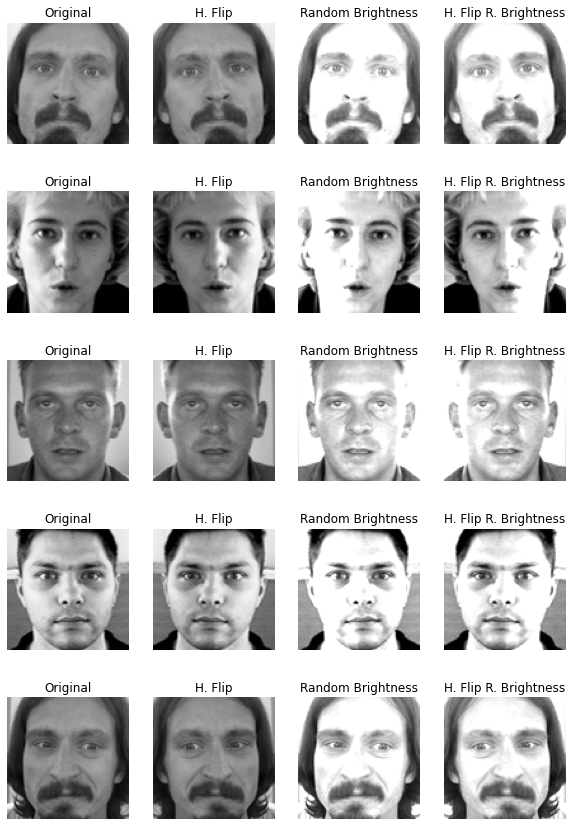

In [16]:
fig = plt.figure(figsize=(10, 15))
s = data.shape[0]
k = 0
titles = ['Original', 'H. Flip', 'Random Brightness', 'H. Flip R. Brightness']
for i in range(5):
    for j in range(4):
        ax = fig.add_subplot(5, 4, k + 1)
        plt.imshow(images[(s*j)+i], cmap='gray')
        ax.set_title(titles[j])
        ax.axis('off')
        k += 1

In [17]:
# Normalize the images
images = images/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(images), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(images)):
    X[i,] = np.expand_dims(images[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [18]:
y = np.asarray(keypoints).astype(np.float32)
y.shape

(8560, 30)

In [19]:
outputs_y = dict()
for k,v in o_ix.items():
    outputs_y[k] = y[:,v]

In [20]:
from sklearn.model_selection import train_test_split

# Split the data into train and test data
X_train, X_test, *y_split = train_test_split(X, *outputs_y.values(), test_size = 0.2)

In [21]:
y_labels = dict()
for i,k in zip(range(0,len(y_split),2), o_ix.keys()):
    y_labels[k+'_train'] = y_split[i]
    y_labels[k+'_test'] = y_split[i+1]

In [30]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

base_model = ResNet50(include_top=False, weights=None, input_shape=(96,96,1))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# predictions = Dense(30)(x)
out_1 = Dense(256, activation='relu')(x)
out_1 = Dense(len(o_ix["left_eye"]), name="out_1")(out_1)

out_2 = Dense(256, activation='relu')(x)
out_2 = Dense(len(o_ix["right_eye"]), name="out_2")(out_2)

out_3 = Dense(256, activation='relu')(x)
out_3 = Dense(len(o_ix["left_eyebrow"]), name="out_3")(out_3)

out_4 = Dense(256, activation='relu')(x)
out_4 = Dense(len(o_ix["right_eyebrow"]), name="out_4")(out_4)

out_5 = Dense(256, activation='relu')(x)
out_5 = Dense(len(o_ix["nose"]), name="out_5")(out_5)

out_6 = Dense(256, activation='relu')(x)
out_6 = Dense(len(o_ix["mouth"]), name="out_6")(out_6)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=[out_1, out_2, out_3, out_4, out_5, out_6])

In [31]:
losses = {
    'out_1': 'mean_squared_error',
    'out_2': 'mean_squared_error',
    'out_3': 'mean_squared_error',
    'out_4': 'mean_squared_error',
    'out_5': 'mean_squared_error',
    'out_6': 'mean_squared_error'
}
loss_weights=[1.0]*6
model.compile(loss = losses, optimizer = "adam", loss_weights=loss_weights)

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)
checkpointer = ModelCheckpoint(filepath=PATH+"KeyPoints_weights.hdf5", verbose=1, save_best_only=True)

In [33]:
y_train = [
    y_labels['left_eye_train'],
    y_labels['right_eye_train'],
    y_labels['left_eyebrow_train'],
    y_labels['right_eyebrow_train'],
    y_labels['nose_train'],
    y_labels['mouth_train']
]
y_test = [
    y_labels['left_eye_test'],
    y_labels['right_eye_test'],
    y_labels['left_eyebrow_test'],
    y_labels['right_eyebrow_test'],
    y_labels['nose_test'],
    y_labels['mouth_test']
]

In [34]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.05, callbacks=[checkpointer, earlystopping])

Epoch 1/10
204/204 [==============================] - 32s 94ms/step - loss: 1039.4337 - out_1_loss: 188.7325 - out_2_loss: 82.4547 - out_3_loss: 185.1786 - out_4_loss: 78.7112 - out_5_loss: 195.8050 - out_6_loss: 308.5516 - val_loss: 807.1633 - val_out_1_loss: 157.8400 - val_out_2_loss: 78.6048 - val_out_3_loss: 156.5060 - val_out_4_loss: 79.3827 - val_out_5_loss: 140.9198 - val_out_6_loss: 193.9100

Epoch 00001: val_loss improved from inf to 807.16327, saving model to drive/MyDrive/Colab Notebooks/EmotionAI/KeyPoints_weights.hdf5
Epoch 2/10
204/204 [==============================] - 18s 88ms/step - loss: 87.3564 - out_1_loss: 9.6878 - out_2_loss: 9.8291 - out_3_loss: 18.5154 - out_4_loss: 18.0270 - out_5_loss: 11.3124 - out_6_loss: 19.9848 - val_loss: 263.3264 - val_out_1_loss: 44.7030 - val_out_2_loss: 22.7228 - val_out_3_loss: 50.3079 - val_out_4_loss: 33.3043 - val_out_5_loss: 46.7798 - val_out_6_loss: 65.5086

Epoch 00002: val_loss improved from 807.16327 to 263.32635, saving mode

In [35]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open(PATH+"KeyPoints-model.json","w") as json_file:
    json_file.write(model_json)

In [36]:
from tensorflow.keras.models import model_from_json

with open(PATH+'KeyPoints-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model = model_from_json(json_savedModel)
model.load_weights(PATH+'KeyPoints_weights.hdf5')
model.compile(loss=losses, optimizer="adam", loss_weights=loss_weights)

In [38]:
# Evaluate the model

result = model.evaluate(X_test, y_test)
print(result[0])

54/54 [==============================] - 1s 25ms/step - loss: 73.2840 - out_1_loss: 7.6409 - out_2_loss: 8.9187 - out_3_loss: 13.9947 - out_4_loss: 14.7032 - out_5_loss: 9.0821 - out_6_loss: 18.9444
[73.2840347290039, 7.6408772468566895, 8.918704986572266, 13.9946928024292, 14.703205108642578, 9.08214282989502, 18.944414138793945]


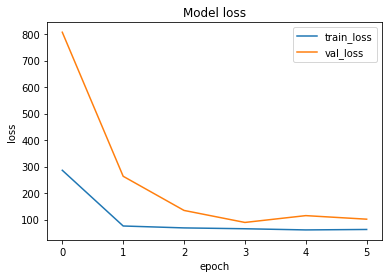

In [39]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

In [ ]:
predictions = model.predict(X_test)

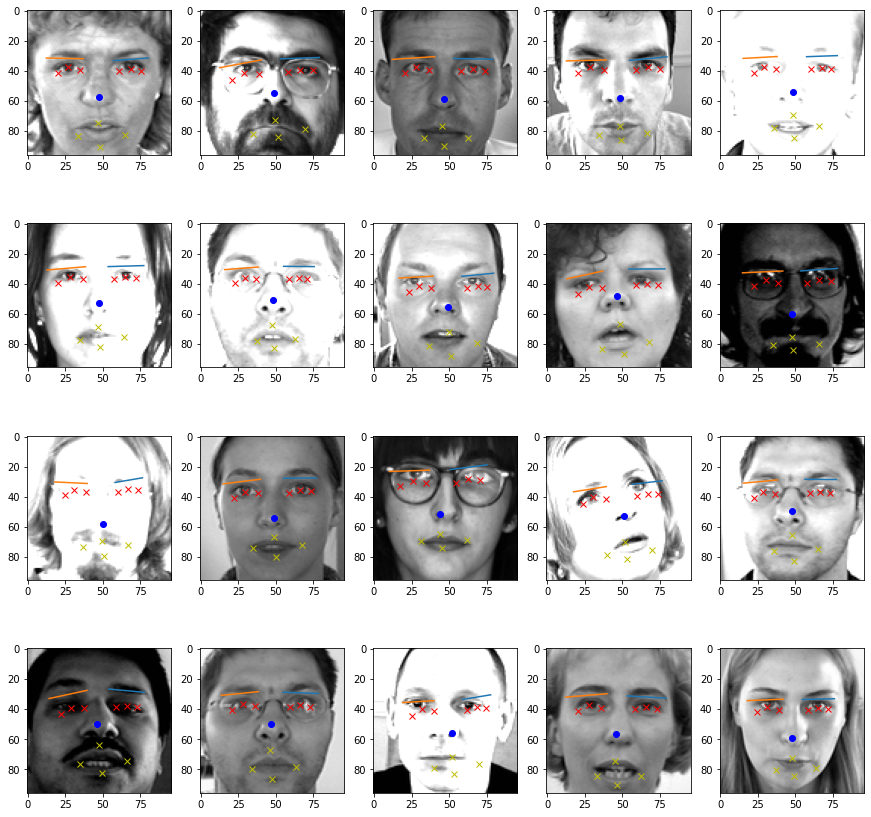

In [57]:
fig = plt.figure(figsize=(15, 15))

for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1)    
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    for j in range(1,len(o_ix["left_eye"]),2):
        plt.plot(predictions[0][i][j-1], predictions[0][i][j], 'rx')
    # plt.plot(predictions[0][i][::2], predictions[0][i][1::2])

    for j in range(1,len(o_ix["right_eye"]),2):
        plt.plot(predictions[1][i][j-1], predictions[1][i][j], 'rx')
    # plt.plot(predictions[1][i][::2], predictions[1][i][1::2])
    
    # for j in range(1,len(o_ix["left_eyebrow"]),2):
    #     plt.plot(predictions[2][i][j-1], predictions[2][i][j], 'gx')
    plt.plot(predictions[2][i][::2], predictions[2][i][1::2])
    
    # for j in range(1,len(o_ix["right_eyebrow"]),2):
    #     plt.plot(predictions[3][i][j-1], predictions[3][i][j], 'gx')
    plt.plot(predictions[3][i][::2], predictions[3][i][1::2])
    
    for j in range(1,len(o_ix["nose"]),2):
        plt.plot(predictions[4][i][j-1], predictions[4][i][j], 'bo')
    # plt.plot(predictions[4][i][::2], predictions[4][i][1::2])
    
    for j in range(1,len(o_ix["mouth"]),2):
        plt.plot(predictions[5][i][j-1], predictions[5][i][j], 'yx')    
    # plt.plot(predictions[5][i][::2], predictions[5][i][1::2])